# Transfer Learning Using Inception v3 Model

In [1]:
import os
print(os.environ['HOME'])
print(os.environ['PATH'])
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['CUDA_HOME'])

/home/aas22
/home/aas22/TransferLearning/bin:/home/aas22/TransferLearning/bin:/home/aas22/lib/cuda/bin:/home/aas22/bin:/home/aas22/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
/home/aas22/lib/cuda/lib64/
/home/aas22/lib/cuda/


In [2]:
from PIL import Image
 
def convert_to_black_and_white(image_file_path,bw_image_file_path):
    imagefileNames = [join(image_file_path, f) for f in listdir(image_file_path) if isfile(join(image_file_path, f))]
    bw_imagefileNames = [join(bw_image_file_path,f) for f in listdir(image_file_path) if isfile(join(image_file_path, f))]

    num_images = len(imagefileNames)
    # For each input image.
    for i in range(num_images):
        
        # Status-message. Note the \r which means the line should overwrite itself.
        msg = "\r- Processing image: {0:>6} / {1}".format(i+1, num_images)

        # Print the status message.
        sys.stdout.write(msg)
        sys.stdout.flush()
        color_image = Image.open(imagefileNames[i])
        #bw = color_image.convert('L')
        gray = color_image.convert('L')
        bw = gray.point(lambda x: 0 if x<128 else 255, '1')
        
        
        bw.save(bw_imagefileNames[i])

In [3]:
convert_to_black_and_white('/home/aas22/TransferLearning/celeba-raw-images/','/home/aas22/TransferLearning/celeba-bw-raw-images/')

NameError: name 'listdir' is not defined

In [4]:
def create_transfer_value_files(image_file_path,value_file_path):
    # Functions and classes for loading and using the Inception model.
       
    inceptionModel = inception.Inception()
    
    imagefileNames = [join(image_file_path, f) for f in listdir(image_file_path) if isfile(join(image_file_path, f))]
    
    #print (', '.join(imagefileNames))
    
    transferValuefileNames = [join(value_file_path,f.replace('.jpg','.pkl')) for f in listdir(image_file_path) if isfile(join(image_file_path, f))]

    #print (', '.join(transferValuefileNames))
    
    num_images = len(imagefileNames)
    
    print('num_images: ', num_images)

    # Pre-allocate list for the results.
    # This holds references to other arrays. Initially the references are None.
    result = [None]

    # For each input image.
    for i in range(num_images):
        
        # Status-message. Note the \r which means the line should overwrite itself.
        msg = "\r- Processing image: {0:>6} / {1}".format(i+1, num_images)

        # Print the status message.
        sys.stdout.write(msg)
        sys.stdout.flush()

        imageFileName = imagefileNames[i]
        
        #print (imageFileName)
        
        # Process the image and store the result for later use.
        result = inceptionModel.transfer_values(image_path=imageFileName)

        # Convert the result to a numpy array.
        result = np.array(result)
        
        cacheFileName = transferValuefileNames[i]
         # Save the data to a cache-file.
        with open(cacheFileName, mode='wb') as file:
            pickle.dump(result, file)
        
    # Print newline.
    print()


    return 

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tensorflow as tf
import os
import sys
import time
from datetime import timedelta
import prettytensor as pt
import inception
import csv
from os import listdir
from os.path import isfile, join
import random
import scipy

#base declaration
num_classes = 2

'''
5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young
'''
#declare the class names (this has to match one of the column names from the previous row)
class_names = ['Attractive','Not-Attractive']

attribute_name = class_names[0]

/home/aas22/TransferLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
import tensorflow as tf

In [7]:
#run this only once
#create_transfer_value_files('/home/aas22/TransferLearning/celeba-raw-images/','/home/aas22/TransferLearning/celeba-inceptionvalue-files/')


In [8]:
#run this only once
#create_transfer_value_files('/home/aas22/TransferLearning/celeba-bw-raw-images/','/home/aas22/TransferLearning/celeba-bw-inceptionvalue-files/')


In [9]:
def read_transfer_value_file(value_file_name):
    # If the cache-file exists.
    if os.path.exists(value_file_name):
        # Load the cached data from the file.
        with open(value_file_name, mode='rb') as file:
            obj = np.load(file)#pickle.load(file)
    else:
        print("The value file: " + value_file_name + " does not exist")
    return obj


def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.

    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]

    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.

    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.

    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]


def create_train_test_data_Set(attribute_name, attribute_file_name,value_file_path,image_file_path):
    attributeOfInterestNdx=0   
    totCnt=0
    colCnt=0
    
    posSamples = []
    negSamples = []
    posImageFileNames = []
    negImageFileNames = []
    
    with open(attribute_file_name, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')
        for row in reader:
            totCnt += 1
            if totCnt == 1:
                #set the attributeOfInterestNdx
                for col in row:
                    if col == attribute_name:
                        attributeOfInterestNdx = colCnt
                    else: 
                        colCnt += 1    
            else:
                fileName = join(value_file_path, row[0].replace('.jpg','.pkl'))
                imgFileName = join(image_file_path, row[0])
                if row[attributeOfInterestNdx]=='1':
                    #this is an example of the positive case
                    posSamples.append(read_transfer_value_file(fileName))
                    posImageFileNames.append(imgFileName)
                else:
                    negSamples.append(read_transfer_value_file(fileName))
                    negImageFileNames.append(imgFileName)
    f.close()   
    
    rareEvent = False
    numPosSamples = len(posSamples)
    numNegSamples = len(negSamples)
    numTotSamples = numPosSamples + numNegSamples
    
    if ((numPosSamples > numNegSamples) and ((numNegSamples/numTotSamples) < 0.05)):
        rareEvent = True
        
    if ((numPosSamples < numNegSamples) and ((numPosSamples/numTotSamples) < 0.05)):
        rareEvent = True    
    
    #Balance the datasets by Random Over-Sampling
    '''
    Advantages
        Unlike under sampling this method leads to no information loss.
        Outperforms under sampling
    Disadvantages
        It increases the likelihood of overfitting since it replicates the minority class events.
        
    if rareEvent == True :
        if (posSamples > negSamples) :
        
        else:
        
    '''
    
    
    #create the training and testing datasets now
    testPrcnt = 4
    posTrainSamples = []
    posTestSamples = []
    posTrainImgFileNames = []
    posTestImgFileNames = []
    i = 0
    #print('posSamples: ', posSamples)
    for sample in posSamples:
        if i%testPrcnt == 0:
            #
            posTestSamples.append(sample)
            posTestImgFileNames.append(posImageFileNames[i])
        else:
            #
            posTrainSamples.append(sample)
            posTrainImgFileNames.append(posImageFileNames[i])
        i+=1
    
    negTestSamples = []
    negTrainSamples = []
    negTrainImgFileNames = []
    negTestImgFileNames = []
    i = 0
    for sample in negSamples:
        if i%testPrcnt == 0:
            #
            negTestSamples.append(sample)
            negTestImgFileNames.append(negImageFileNames[i])
        else:
            #
            negTrainSamples.append(sample)
            negTrainImgFileNames.append(negImageFileNames[i])
        i+=1
    
    totTrainClassNumbers = [0] * len(posTrainSamples) + [1] * len(negTrainSamples) 
    totTrainSamples = posTrainSamples + negTrainSamples
    totTrainImgFileNames = posTrainImgFileNames + negTrainImgFileNames
    print ('Train tot: ',len(totTrainSamples),' pos: ',len(posTrainSamples),' neg: ',len(negTrainSamples))
    combined = list(zip(totTrainSamples, totTrainClassNumbers, totTrainImgFileNames))
    random.shuffle(combined)
    totTrainSamples, totTrainClassNumbers, totTrainImgFileNames = zip(*combined)
    totTrainSamples = np.asarray( totTrainSamples )
    totTrainClassNumbers = np.asarray(totTrainClassNumbers)
    totTrainClassLabels = one_hot_encoded (totTrainClassNumbers, 2)
    totTrainImgFileNames = list (totTrainImgFileNames)
    
    totTestClassNumbers = [0] * len(posTestSamples) + [1] * len(negTestSamples) 
    totTestSamples = posTestSamples + negTestSamples 
    totTestImgFileNames = posTestImgFileNames + negTestImgFileNames
    print ('Test tot: ',len(totTestSamples),' pos: ',len(posTestSamples),' neg: ',len(negTestSamples))
    combined = list(zip(totTestSamples, totTestClassNumbers, totTestImgFileNames))
    random.shuffle(combined)
    totTestSamples, totTestClassNumbers, totTestImgFileNames = zip(*combined)
    totTestSamples = np.asarray( totTestSamples )
    totTestClassNumbers = np.asarray(totTestClassNumbers)
    totTestClassLabels = one_hot_encoded (totTestClassNumbers, 2)
    totTestImgFileNames = list (totTestImgFileNames)
    
    return totTrainImgFileNames,totTrainSamples,totTrainClassNumbers,totTrainClassLabels,totTestImgFileNames,totTestSamples,totTestClassNumbers,totTestClassLabels
    

In [10]:
#image_paths_train,transfer_values_train, cls_train, labels_train, image_paths_test, transfer_values_test, cls_test, labels_test = create_train_test_data_Set('Arched_Eyebrows', '/home/aas22/TransferLearning/CelebATags.txt','/home/aas22/TransferLearning/celeba-inceptionvalue-files/','/home/aas22/TransferLearning/celeba-raw-images')
image_paths_train,transfer_values_train, cls_train, labels_train, image_paths_test, transfer_values_test, cls_test, labels_test = create_train_test_data_Set('Arched_Eyebrows', '/home/aas22/TransferLearning/CelebATags.txt','/home/aas22/TransferLearning/celeba-bw-inceptionvalue-files/','/home/aas22/TransferLearning/celeba-bw-raw-images')

print ('Training Sample Data Shape: ', transfer_values_train.shape)

print ('Testing Sample Data Shape: ', transfer_values_test.shape)

Train tot:  151948  pos:  40567  neg:  111381
Test tot:  50651  pos:  13523  neg:  37128
Training Sample Data Shape:  (151948, 2048)
Testing Sample Data Shape:  (50651, 2048)


In [11]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()
    

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


Input image:


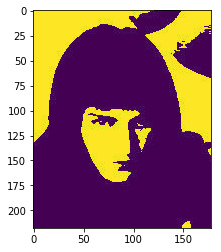

Transfer-values for the image using Inception model:


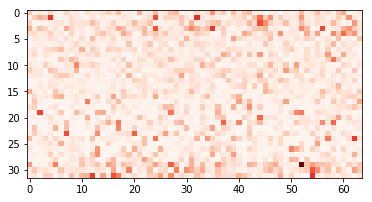

In [12]:
plot_transfer_values(i=150)

In [13]:
transfer_len = len(transfer_values_train[0])
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

global_step = tf.Variable(initial_value=0,name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()
session.run(tf.global_variables_initializer())

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [14]:
train_batch_size = 64


def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the indices for the incorrectly classified images.
    idx = np.flatnonzero(incorrect)

    # Number of images to select, max 9.
    n = min(len(idx), 9)
    
    # Randomize and select n indices.
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # Get the predicted classes for those images.
    cls_pred = cls_pred[idx]

    # Get the true classes for those images.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # Note: We cannot do image_paths_test[idx] on lists of strings.
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # Plot the images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)
    
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers)) 


# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [15]:
print_test_accuracy(show_example_errors=False,show_confusion_matrix=True)

Accuracy on Test-Set: 45.3% (22951 / 50651)
Confusion Matrix:
[10660  2863] (0) Attractive
[24837 12291] (1) Not-Attractive
 (0) (1)


In [16]:
optimize(num_iterations=50000)

Global Step:    100, Training Batch Accuracy:  81.2%
Global Step:    200, Training Batch Accuracy:  79.7%
Global Step:    300, Training Batch Accuracy:  70.3%
Global Step:    400, Training Batch Accuracy:  71.9%
Global Step:    500, Training Batch Accuracy:  68.8%
Global Step:    600, Training Batch Accuracy:  73.4%
Global Step:    700, Training Batch Accuracy:  82.8%
Global Step:    800, Training Batch Accuracy:  73.4%
Global Step:    900, Training Batch Accuracy:  75.0%
Global Step:   1000, Training Batch Accuracy:  76.6%
Global Step:   1100, Training Batch Accuracy:  75.0%
Global Step:   1200, Training Batch Accuracy:  68.8%
Global Step:   1300, Training Batch Accuracy:  67.2%
Global Step:   1400, Training Batch Accuracy:  79.7%
Global Step:   1500, Training Batch Accuracy:  81.2%
Global Step:   1600, Training Batch Accuracy:  71.9%
Global Step:   1700, Training Batch Accuracy:  71.9%
Global Step:   1800, Training Batch Accuracy:  82.8%
Global Step:   1900, Training Batch Accuracy: 

Global Step:  15600, Training Batch Accuracy:  81.2%
Global Step:  15700, Training Batch Accuracy:  78.1%
Global Step:  15800, Training Batch Accuracy:  78.1%
Global Step:  15900, Training Batch Accuracy:  84.4%
Global Step:  16000, Training Batch Accuracy:  84.4%
Global Step:  16100, Training Batch Accuracy:  73.4%
Global Step:  16200, Training Batch Accuracy:  84.4%
Global Step:  16300, Training Batch Accuracy:  84.4%
Global Step:  16400, Training Batch Accuracy:  84.4%
Global Step:  16500, Training Batch Accuracy:  79.7%
Global Step:  16600, Training Batch Accuracy:  81.2%
Global Step:  16700, Training Batch Accuracy:  85.9%
Global Step:  16800, Training Batch Accuracy:  89.1%
Global Step:  16900, Training Batch Accuracy:  76.6%
Global Step:  17000, Training Batch Accuracy:  76.6%
Global Step:  17100, Training Batch Accuracy:  71.9%
Global Step:  17200, Training Batch Accuracy:  81.2%
Global Step:  17300, Training Batch Accuracy:  76.6%
Global Step:  17400, Training Batch Accuracy: 

Global Step:  31100, Training Batch Accuracy:  78.1%
Global Step:  31200, Training Batch Accuracy:  90.6%
Global Step:  31300, Training Batch Accuracy:  84.4%
Global Step:  31400, Training Batch Accuracy:  78.1%
Global Step:  31500, Training Batch Accuracy:  85.9%
Global Step:  31600, Training Batch Accuracy:  87.5%
Global Step:  31700, Training Batch Accuracy:  89.1%
Global Step:  31800, Training Batch Accuracy:  81.2%
Global Step:  31900, Training Batch Accuracy:  84.4%
Global Step:  32000, Training Batch Accuracy:  87.5%
Global Step:  32100, Training Batch Accuracy:  87.5%
Global Step:  32200, Training Batch Accuracy:  82.8%
Global Step:  32300, Training Batch Accuracy:  87.5%
Global Step:  32400, Training Batch Accuracy:  79.7%
Global Step:  32500, Training Batch Accuracy:  76.6%
Global Step:  32600, Training Batch Accuracy:  85.9%
Global Step:  32700, Training Batch Accuracy:  89.1%
Global Step:  32800, Training Batch Accuracy:  78.1%
Global Step:  32900, Training Batch Accuracy: 

Global Step:  46600, Training Batch Accuracy:  93.8%
Global Step:  46700, Training Batch Accuracy:  87.5%
Global Step:  46800, Training Batch Accuracy:  90.6%
Global Step:  46900, Training Batch Accuracy:  85.9%
Global Step:  47000, Training Batch Accuracy:  82.8%
Global Step:  47100, Training Batch Accuracy:  87.5%
Global Step:  47200, Training Batch Accuracy:  89.1%
Global Step:  47300, Training Batch Accuracy:  92.2%
Global Step:  47400, Training Batch Accuracy:  84.4%
Global Step:  47500, Training Batch Accuracy:  87.5%
Global Step:  47600, Training Batch Accuracy:  87.5%
Global Step:  47700, Training Batch Accuracy:  90.6%
Global Step:  47800, Training Batch Accuracy:  92.2%
Global Step:  47900, Training Batch Accuracy:  84.4%
Global Step:  48000, Training Batch Accuracy:  90.6%
Global Step:  48100, Training Batch Accuracy:  90.6%
Global Step:  48200, Training Batch Accuracy:  95.3%
Global Step:  48300, Training Batch Accuracy:  84.4%
Global Step:  48400, Training Batch Accuracy: 

Accuracy on Test-Set: 74.2% (37562 / 50651)
Example errors:


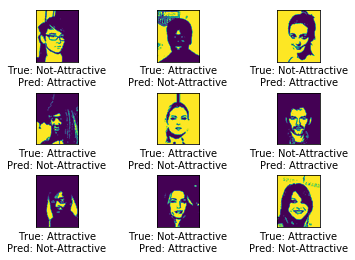

Confusion Matrix:
[6715 6808] (0) Attractive
[ 6281 30847] (1) Not-Attractive
 (0) (1)


In [19]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)